<a href="https://colab.research.google.com/github/feryah/Data_Science_Portfolio/blob/master/baby_names_RNN-GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
names=pd.read_csv('/content/names.txt', encoding="ISO-8859-1")

names = names.drop_duplicates()

names.head()

,name
0,aaliyah
1,aapeli
2,aapo
3,aaren
4,aarne


The RNN needs to understand where is the beginning and the end of a word. So we need to add a new character at the beginning of every word, for example '\t' (it could be anything else as long as it can be identified easily). We can also add '\n' to the end of every word as the end.

In [4]:
names['name'] = names['name'].apply(lambda x: '\t'+str(x)+'\n')
names.head()

,name
0,\taaliyah\n
1,\taapeli\n
2,\taapo\n
3,\taaren\n
4,\taarne\n


To generate names, we will have to play at the character level: we will train a RNN to predict the next character, knowing the previous one. So, compute a list of all the possible characters.

In [5]:
all_chars = set()
for name in names.name:
  for c in name:
    if c not in all_chars:
      all_chars.add(c)
all_chars.add('\n')

print('number of characters', len(all_chars))
print(all_chars)

number of characters 55
{'ç', 'ð', 'i', 'é', 'y', 'ñ', 'p', 'q', 'æ', 'ó', 'ö', 'j', 'à', 'a', 'o', 'ã', 'e', 'í', 'ø', 'ü', 'ò', 'ä', 'f', 'x', 'õ', 'm', '\t', 'ô', 'å', 'g', 'z', 'ì', 'ù', '\n', 'n', 'k', 'w', 'v', 'ë', '-', 'l', 'è', 'c', 'ê', 'u', 'þ', 'd', 'r', 'h', 'á', 't', 'ï', 'ú', 'b', 's'}


As usual when playing with characters (or words), we will convert them into integers. So build a dictionary char_to_idx that, given a character as key, returns an integer. And build the opposite dictionary idx_to_char that, given an integer as key, returns the corresponding character.

In [10]:
char_to_idx =  {k:v for v, k in enumerate(sorted(all_chars))}
char_to_idx

{'\t': 0,
 '\n': 1,
 '-': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28,
 'à': 29,
 'á': 30,
 'ã': 31,
 'ä': 32,
 'å': 33,
 'æ': 34,
 'ç': 35,
 'è': 36,
 'é': 37,
 'ê': 38,
 'ë': 39,
 'ì': 40,
 'í': 41,
 'ï': 42,
 'ð': 43,
 'ñ': 44,
 'ò': 45,
 'ó': 46,
 'ô': 47,
 'õ': 48,
 'ö': 49,
 'ø': 50,
 'ù': 51,
 'ú': 52,
 'ü': 53,
 'þ': 54}

In [11]:
idx_to_chars =  {k:v for k, v in enumerate(sorted(all_chars))}
idx_to_chars

{0: '\t',
 1: '\n',
 2: '-',
 3: 'a',
 4: 'b',
 5: 'c',
 6: 'd',
 7: 'e',
 8: 'f',
 9: 'g',
 10: 'h',
 11: 'i',
 12: 'j',
 13: 'k',
 14: 'l',
 15: 'm',
 16: 'n',
 17: 'o',
 18: 'p',
 19: 'q',
 20: 'r',
 21: 's',
 22: 't',
 23: 'u',
 24: 'v',
 25: 'w',
 26: 'x',
 27: 'y',
 28: 'z',
 29: 'à',
 30: 'á',
 31: 'ã',
 32: 'ä',
 33: 'å',
 34: 'æ',
 35: 'ç',
 36: 'è',
 37: 'é',
 38: 'ê',
 39: 'ë',
 40: 'ì',
 41: 'í',
 42: 'ï',
 43: 'ð',
 44: 'ñ',
 45: 'ò',
 46: 'ó',
 47: 'ô',
 48: 'õ',
 49: 'ö',
 50: 'ø',
 51: 'ù',
 52: 'ú',
 53: 'ü',
 54: 'þ'}

Before going into the neural network part, we have one more step: create the X and y data!

So the X data is going to be, for every name, all but the '\n' character. The y data will be all but the '\t' character.

Indeed, we will try to predict the following character knowing the previous. To the X does not need the final character, and the y does not need the first character.

Create the columns X and y to the dataframe.

In [12]:
names['X'] = names["name"].apply(lambda x: x[:len(x)-1])
names['y'] = names["name"].apply(lambda x: x[1:len(x)])

In [13]:
names.head()

,name,X,y
0,\taaliyah\n,\taaliyah,aaliyah\n
1,\taapeli\n,\taapeli,aapeli\n
2,\taapo\n,\taapo,aapo\n
3,\taaren\n,\taaren,aaren\n
4,\taarne\n,\taarne,aarne\n


Now, using your char_to_idx dict, compute the corresponding X and y containing, for each name, a list of integers.

In [14]:
X = names['X'].apply(lambda x: [char_to_idx[c] for c in x])
y = names['y'].apply(lambda x: [char_to_idx[c] for c in x])

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [28]:
from tensorflow.keras.preprocessing import sequence

maxlen = 16

X_train = sequence.pad_sequences(X_train,
                                 value=0,
                                 padding='post',
                                 maxlen=maxlen)

y_train = sequence.pad_sequences(y_train,
                                 value=0,
                                 padding='post',
                                 maxlen=maxlen)

X_test = sequence.pad_sequences(X_test,
                                 value=0,
                                 padding='post',
                                 maxlen=maxlen)

y_test = sequence.pad_sequences(y_test,
                                 value=0,
                                 padding='post',
                                 maxlen=maxlen)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9197, 16), (9197, 16), (2300, 16), (2300, 16))

In [29]:
from tensorflow.keras.utils import to_categorical


X_train = to_categorical(X_train)
y_train = to_categorical(y_train)

X_test = to_categorical(X_test)
y_test = to_categorical(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9197, 16, 55), (9197, 16, 55), (2300, 16, 55), (2300, 16, 55))

You should finally have arrays of shape (number of names, 16, 55):

- 16 is the sequence length
- 55 is the number of possible characters
  - Now you have to build a neural network. You can for example use one or two layers of GRU (or LSTM). Do not forget to set return_sequences=True.

Then you will have to add a TimeDistributed(Dense(55)) with a softmax activation function. This layer will handle the fact you have a dense layer at each time step with a softmax prediction of the next word.

'TimeDistributedDense' applies a same dense to every time step during GRU/LSTM Cell unrolling. So the error function will be between predicted label sequence and the actual label sequence. (Which is normally the requirement for sequence to sequence labeling problems).

However, with return_sequences=False, Dense layer is applied only once at the last cell. This is normally the case when RNNs are used for classification problem. If return_sequences=True then Dense layer is applied to every timestep just like TimeDistributedDense.

We will also be tunining hypermarameters to avoid overfitting.

Epoch 1/50
144/144 [==============================] - 4s 6ms/step - loss: 13.3637 - accuracy: 0.4818
Epoch 2/50
144/144 [==============================] - 1s 6ms/step - loss: 3.0014 - accuracy: 0.5508
Epoch 3/50
144/144 [==============================] - 1s 6ms/step - loss: 2.0040 - accuracy: 0.5550
Epoch 4/50
144/144 [==============================] - 1s 6ms/step - loss: 1.8756 - accuracy: 0.5613
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 1.8233 - accuracy: 0.5772
Epoch 6/50
144/144 [==============================] - 1s 6ms/step - loss: 1.7995 - accuracy: 0.5824
Epoch 7/50
144/144 [==============================] - 1s 6ms/step - loss: 1.7660 - accuracy: 0.5891
Epoch 8/50
144/144 [==============================] - 1s 6ms/step - loss: 1.7510 - accuracy: 0.5874
Epoch 9/50
144/144 [==============================] - 1s 6ms/step - loss: 1.7327 - accuracy: 0.5884
Epoch 10/50
144/144 [==============================] - 1s 6ms/step - loss: 1.7166 - accuracy: 0.586

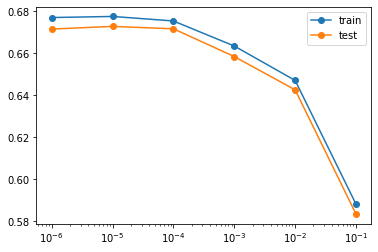

In [36]:
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed
from tensorflow.keras.models import Sequential

from tensorflow.keras import regularizers

from matplotlib import pyplot


reguls = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
drops = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
all_train, all_test = list(), list()
for regul, dropout in zip(reguls, drops):
	# define model
  model = Sequential()
  model.add(GRU(32, activation='tanh', input_shape=(maxlen, len(all_chars)), kernel_regularizer=regularizers.l2(regul), 
                return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(32, activation='tanh', kernel_regularizer=regularizers.l2(regul), return_sequences=True))
  model.add(TimeDistributed(Dense(len(all_chars), activation='softmax', kernel_regularizer=regularizers.l2(regul))))
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, batch_size=64, epochs=50)
  
  # evaluate the model
  _, train_acc = model.evaluate(X_train, y_train, verbose=0)
  _, test_acc = model.evaluate(X_test, y_test, verbose=0)
  print('Param: %f, Dropout: %f, Train: %.3f, Test: %.3f' % (regul, dropout, train_acc, test_acc))
  all_train.append(train_acc)
  all_test.append(test_acc)

# plot train and test means
pyplot.semilogx(reguls, all_train, label='train', marker='o')
pyplot.semilogx(reguls, all_test, label='test', marker='o')
pyplot.legend()
pyplot.show()

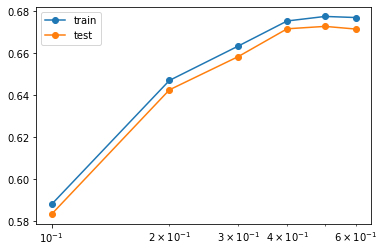

In [38]:
pyplot.semilogx(drops, all_train, label='train', marker='o')
pyplot.semilogx(drops, all_test, label='test', marker='o')
pyplot.legend()
pyplot.show()

In [39]:
model = Sequential()
model.add(GRU(32, activation='tanh', input_shape=(maxlen, len(all_chars)), kernel_regularizer=regularizers.l2(1e-6), 
                return_sequences=True))
model.add(Dropout(0.6))
model.add(GRU(32, activation='tanh', kernel_regularizer=regularizers.l2(1e-6), return_sequences=True))
model.add(TimeDistributed(Dense(len(all_chars), activation='softmax', kernel_regularizer=regularizers.l2(1e-6))))
  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
144/144 [==============================] - 5s 6ms/step - loss: 2.9641 - accuracy: 0.4219
Epoch 2/50
144/144 [==============================] - 1s 6ms/step - loss: 1.5275 - accuracy: 0.5735
Epoch 3/50
144/144 [==============================] - 1s 6ms/step - loss: 1.3521 - accuracy: 0.6274
Epoch 4/50
144/144 [==============================] - 1s 6ms/step - loss: 1.2817 - accuracy: 0.6414
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 1.2597 - accuracy: 0.6442
Epoch 6/50
144/144 [==============================] - 1s 6ms/step - loss: 1.2257 - accuracy: 0.6521
Epoch 7/50
144/144 [==============================] - 1s 6ms/step - loss: 1.1975 - accuracy: 0.6562
Epoch 8/50
144/144 [==============================] - 1s 6ms/step - loss: 1.1795 - accuracy: 0.6567
Epoch 9/50
144/144 [==============================] - 1s 6ms/step - loss: 1.1669 - accuracy: 0.6581
Epoch 10/50
144/144 [==============================] - 1s 6ms/step - loss: 1.1552 - accuracy: 0.6605

In [40]:
import numpy as np

def generate_n_names(n, max_len, char_to_idx, model):
    """
    Generate n names automatically
    
    Returns:

    parameters:
    -- n: the number of names to generate (int)
    -- max_len: the length of the sequence
    -- char_to_idx: the dict giving the char corresponding to each idx
    -- model: the trained model that will be used to generate names
    """
    for _ in range(n):
        stop=False
        ch='\t'
        counter=1
        target_seq = np.zeros((1, max_len, len(char_to_idx)))
        target_seq[0, 0, char_to_idx[ch]] = 1.
        while stop == False and counter < 10:
            #sample the data
            probs = model.predict_proba(target_seq, verbose=0)[:, counter-1, :]
            c = np.random.choice(list(char_to_idx.keys()), replace=False, p=probs.reshape(len(char_to_idx)))
            if c=='\n':
                stop=True
            else:
                ch=ch+c
                target_seq[0, counter ,char_to_idx[c]] = 1.
                counter=counter+1
        print(ch)


In [41]:
generate_n_names(20, maxlen, char_to_idx, model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


	agan
	hospildo
	cerins
	eristsya
	reline
	etrich
	chansindy
	kredya
	esmesta
	garine
	aran
	reega
	tewaplig
	dlam
	nhanca
	shargunlu
	rigzil
	pìbronnig
	gkrinelle
	dunya
